In [175]:
# -----------------------------------------------------------------------------------
# Imports de toda la ejecucion
# -----------------------------------------------------------------------------------
%matplotlib inline

from qiskit import *
from qiskit.providers.aer import noise
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [176]:
# -----------------------------------------------------------------------------------
# Enparejamiento de Qubits del chip
# -----------------------------------------------------------------------------------
device = provider.get_backend('ibmq_5_yorktown')
properties = device.properties()
coupling_map = device.configuration().coupling_map

print(coupling_map)

[[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [3, 2], [3, 4], [4, 2], [4, 3]]


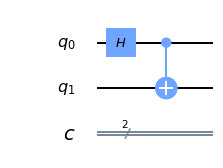

In [177]:
# -----------------------------------------------------------------------------------
# Circuito de ejemplo a usar
# -----------------------------------------------------------------------------------
bb = QuantumCircuit(2, 2)
bb.h(0)
bb.cx(0,1)

bb.draw(output='mpl')

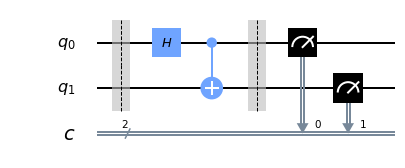

In [178]:
# -----------------------------------------------------------------------------------
# Mediciones agnadidas al circuito
# -----------------------------------------------------------------------------------
circuit = QuantumCircuit(2, 2)
circuit.barrier()
circuit +=bb
circuit.barrier()
circuit.measure([0, 1], [0,1])

circuit.draw(output='mpl')

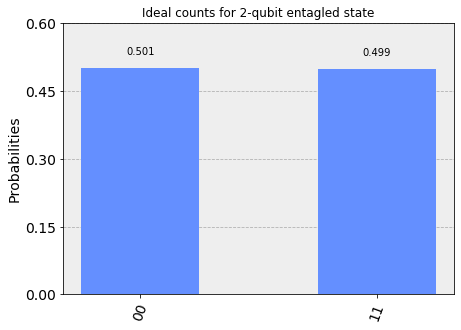

In [179]:
# -----------------------------------------------------------------------------------
# Simulacion local
# Obtencion del estado 'ideal'
# -----------------------------------------------------------------------------------
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, simulator).result()
counts = result.get_counts(circuit)

plot_histogram(counts, title='Ideal counts for 2-qubit entagled state')

Job Status: job has successfully run


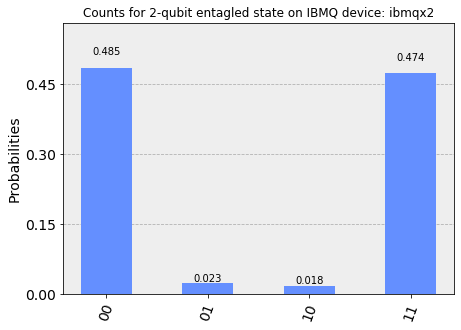

In [170]:
# -----------------------------------------------------------------------------------
# Ejecucion real
# Ejecutado en ibmq_5_yorktown
# -----------------------------------------------------------------------------------
job_device = execute(circuit, device)
job_monitor(job_device)
result_device = job_device.result()
counts_device = result_device.get_counts(0)

plot_histogram(counts_device, title='Counts for 2-qubit entagled state on IBMQ device: {}'.format(device.name()))

In [180]:
# -----------------------------------------------------------------------------------
# Generacion del modelo de ruido
# Creemos que la transpilacion deja igual al circuito por lo que
# solo le afecta la cx(0, 1)
# -----------------------------------------------------------------------------------
gate_times = [
    ('u1', None, 0), ('u2', None, 100), ('u3', None, 200)
    , ('cx', [0, 1], 870)    #870ns calculado desde lo datos del chipset
    , ('cx', [], 0)
]

# Construct the noise model from backend properties
# and custom gate times
noise_model = noise.device.basic_device_noise_model(properties, gate_lengths=gate_times)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'cx', 'id', 'u2', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 3]), ('cx', [2, 4]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [4, 2]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


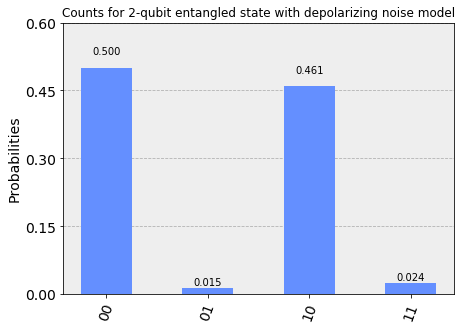

In [167]:
# -----------------------------------------------------------------------------------
# Simulacion local con modelo de ruido
# Deberia asemejarse al resultado de la ejecucion real
# -----------------------------------------------------------------------------------
basis_gates = noise_model.basis_gates
simulator2 = Aer.get_backend('qasm_simulator')
result_noise = execute(circuit, simulator2, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circuit)

plot_histogram(counts_noise, title="Counts for 2-qubit entangled state with depolarizing noise model")

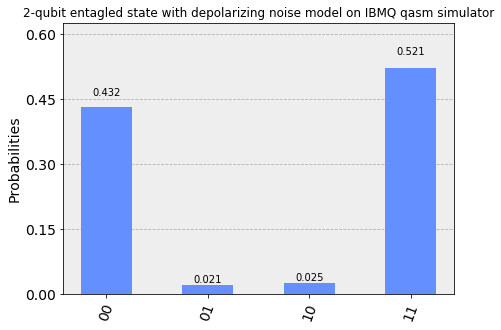

In [169]:
# -----------------------------------------------------------------------------------
# Simulacion online con modelo de ruido
# Deberia asemejarse al resultado de la ejecucion real
# -----------------------------------------------------------------------------------
simulator3 = provider.get_backend('ibmq_qasm_simulator')
result_noise = execute(circuit, simulator3, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circuit)

plot_histogram(counts_noise, title="2-qubit entagled state with depolarizing noise model on IBMQ qasm simulator")